# 🎯 Topic Modeling LDA - Offres d'Emploi Tech/Data/IA

## Analyse des Profils Types d'Offres

**Objectifs** :
1. Découvrir les **thèmes latents** (topics) dans les offres
2. Identifier les **profils types** recherchés
3. Comparer **LDA vs NMF**
4. Visualiser et interpréter les résultats

**Approche** :
- Topic modeling sur les **TITRES** (plus informatifs que descriptions)
- Déduplication des offres identiques
- Lemmatisation avec spaCy
- LDA (Latent Dirichlet Allocation)

---

## 📦 Imports et Configuration

In [5]:
# Imports
import os
import sys
import psycopg2
import pandas as pd
import numpy as np
from dotenv import load_dotenv

# NLP & Text Mining
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Utils
from bs4 import BeautifulSoup
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

# Config
load_dotenv()
DATABASE_URL = os.getenv('DATABASE_URL')

print("✅ Imports OK")

✅ Imports OK


In [8]:
# Charger modèle spaCy français
try:
    nlp = spacy.load("fr_core_news_md")
    print("✅ Modèle spaCy chargé")
except:
    print("❌ Erreur : Installer avec 'python -m spacy download fr_core_news_md'")
    raise

✅ Modèle spaCy chargé


## 1️⃣ Chargement Données

In [9]:
# Connexion BDD
conn = psycopg2.connect(DATABASE_URL)

# Charger TOUTES les offres
query = """
SELECT 
    offer_id,
    title,
    description,
    company_name
FROM fact_job_offers
WHERE title IS NOT NULL AND description IS NOT NULL
ORDER BY offer_id
"""

df = pd.read_sql(query, conn)
conn.close()

print(f"📊 {len(df):,} offres chargées")
print(f"\nAperçu des titres :")
df['title'].head(10)

📊 4,981 offres chargées

Aperçu des titres :


0                                         Data Analyst
1                                       Data Scientist
2     Directeur systèmes d'information indépendant H/F
3     Directeur systèmes d'information indépendant H/F
4     Directeur systèmes d'information indépendant H/F
5     Directeur systèmes d'information indépendant H/F
6    Chef(fe) de projet datas et systèmes informati...
7    DIRECTEUR DES SYSTÈMES D'INFORMATION INDÉPENDA...
8     Directeur systèmes d'information indépendant H/F
9     Directeur systèmes d'information indépendant H/F
Name: title, dtype: object

## 2️⃣ Filtrage Tech/Data/IA

In [10]:
print("🔍 Filtrage des offres Tech/Data/IA...\n")

# Mots-clés pour identifier offres tech
TECH_KEYWORDS = [
    # Data / IA
    'data', 'données', 'machine learning', 'ml', 'ia', 'ai',
    'data scientist', 'data analyst', 'data engineer',
    'big data', 'analytics', 'bi', 'business intelligence',
    
    # Développement
    'développeur', 'developpeur', 'developer',
    'java', 'python', 'javascript', 'php', 'c++', '.net',
    'react', 'angular', 'vue', 'nodejs',
    'backend', 'frontend', 'fullstack', 'full stack',
    
    # Infrastructure / Cloud
    'devops', 'cloud', 'aws', 'azure', 'gcp',
    'docker', 'kubernetes', 'terraform', 'ansible',
    'administrateur', 'système', 'systeme', 'réseau', 'reseau',
    
    # Autres métiers tech
    'ingénieur', 'ingenieur', 'architecte',
    'chef de projet', 'scrum master', 'product owner',
    'consultant', 'analyste', 'testeur', 'qa',
    'cybersécurité', 'cybersecurite', 'sécurité', 'securite',
    'informatique', 'it', 'erp', 'crm', 'sql',
]

def is_tech_offer(title):
    """Vérifie si l'offre est tech (basé sur le titre)"""
    title_lower = str(title).lower()
    return any(kw in title_lower for kw in TECH_KEYWORDS)

# Filtrer
df_tech = df[df['title'].apply(is_tech_offer)].copy()

print(f"   Avant filtrage : {len(df):,} offres")
print(f"   Après filtrage : {len(df_tech):,} offres tech")
print(f"   → {len(df_tech)/len(df)*100:.1f}% du corpus")

# Utiliser corpus filtré
df = df_tech

🔍 Filtrage des offres Tech/Data/IA...

   Avant filtrage : 4,981 offres
   Après filtrage : 3,443 offres tech
   → 69.1% du corpus


## 3️⃣ Déduplication

In [11]:
print("🔄 Analyse des doublons...\n")

# Compter titres identiques
title_counts = df['title'].value_counts()

print("📊 Top 15 titres les plus fréquents :")
for title, count in title_counts.head(15).items():
    print(f"   {title[:70]:70} : {count:3}x")

# Dédupliquer : garder max 3 offres par titre
df_dedup = df.groupby('title', as_index=False).head(3)

print(f"\n   Avant déduplication : {len(df):,} offres")
print(f"   Après déduplication : {len(df_dedup):,} offres")
print(f"   → {len(df) - len(df_dedup):,} doublons supprimés")

# Utiliser corpus dédupliqué
df = df_dedup

🔄 Analyse des doublons...

📊 Top 15 titres les plus fréquents :
   DIRECTEUR COMMUNICATION & MARKETING DIGITAL - INDEPENDANT (H/F)        : 162x
   Consultant indépendant en performance d'entreprise (H/F)               :  96x
   Enquêteur / Enquêtrice terrain (H/F)                                   :  84x
   Directeur commercial indépendant H/F                                   :  56x
   Directeur systèmes d'information indépendant H/F                       :  56x
   DIRECTEUR COMMERCIAL INDEPENDANT (H/F)                                 :  50x
   DIRECTEUR DES SYSTÈMES D'INFORMATION INDÉPENDANT (H/F)                 :  15x
   Gestionnaire de paie H/F (CDI)                                         :  13x
   Ingénieur d'Etudes VRD (H/F)                                           :  13x
   Enquêteur Terrain - Satisfaction Client (H/F)                          :  11x
   Technicien informatique en alternance H/F                              :  11x
   Conseiller clientèle en milieu hospitalier

## 4️⃣ Échantillonnage pour Topic Modeling

In [12]:
# Prendre échantillon (ajuster selon temps disponible)
# 300-500 offres = bon compromis qualité/temps

SAMPLE_SIZE = 500  # Modifier si nécessaire

if len(df) > SAMPLE_SIZE:
    df_sample = df.sample(n=SAMPLE_SIZE, random_state=42).copy()
    print(f"📊 Échantillon aléatoire de {SAMPLE_SIZE} offres")
else:
    df_sample = df.copy()
    print(f"📊 Utilisation de toutes les {len(df)} offres")

print(f"\nExemples de titres dans l'échantillon :")
for title in df_sample['title'].head(10):
    print(f"   - {title}")

📊 Échantillon aléatoire de 500 offres

Exemples de titres dans l'échantillon :
   - Copy of Ingénieur Big Data - Services Financiers - Bordeaux (H/F)
   - Responsable commercial 63 H/F
   - Ingénieur Systèmes et Réseaux (H/F)
   - Responsable Conformité Financière et Métiers H/F (CDI)
   - Ingénieur(e) PMO H/F
   - Architecte MDM (F/H)
   - DIRECTEUR DES SYSTÈMES D'INFORMATION GROUPE - H/F
   - Consultant Support Applicatif @ groupe international - H/F - La Réunion.
   - Ingénieur·e Système OpenShift (H/F)
   - Chef de Produit F/H - Marketing (H/F)


## 5️⃣ Nettoyage Titres

In [13]:
def clean_title(title):
    """Nettoie le titre d'une offre"""
    if not title:
        return ""
    
    title = title.lower()
    
    # Retirer annotations (h/f), (f/h), etc.
    title = re.sub(r'\(h/f\)|\(f/h\)|\bh/f\b|\bf/h\b', '', title)
    
    # Retirer types de contrat
    title = re.sub(r'\(cdi\)|\(cdd\)|\bstage\b|\balternance\b', '', title, flags=re.IGNORECASE)
    
    # Retirer ponctuation excessive
    title = re.sub(r'[^\w\s\-]', ' ', title)
    
    # Normaliser espaces
    title = re.sub(r'\s+', ' ', title).strip()
    
    return title

# Appliquer nettoyage
df_sample['title_cleaned'] = df_sample['title'].apply(clean_title)

print("✅ Titres nettoyés\n")
print("Exemples AVANT / APRÈS nettoyage :\n")
for i in range(5):
    print(f"Avant : {df_sample['title'].iloc[i]}")
    print(f"Après : {df_sample['title_cleaned'].iloc[i]}")
    print()

✅ Titres nettoyés

Exemples AVANT / APRÈS nettoyage :

Avant : Copy of Ingénieur Big Data - Services Financiers - Bordeaux (H/F)
Après : copy of ingénieur big data - services financiers - bordeaux

Avant : Responsable commercial 63 H/F
Après : responsable commercial 63

Avant : Ingénieur Systèmes et Réseaux (H/F)
Après : ingénieur systèmes et réseaux

Avant : Responsable Conformité Financière et Métiers H/F (CDI)
Après : responsable conformité financière et métiers

Avant : Ingénieur(e) PMO H/F
Après : ingénieur e pmo



## 6️⃣ Lemmatisation des Titres avec spaCy

In [14]:
# Stopwords spécifiques aux titres d'offres
TITLE_STOPWORDS = set([
    # Français de base
    'le', 'la', 'les', 'un', 'une', 'des', 'de', 'du', 'au', 'aux',
    'et', 'ou', 'pour', 'avec', 'sans', 'sur', 'sous', 'dans',
    
    # Niveaux d'expérience
    'junior', 'senior', 'confirmé', 'confirme', 'expérimenté', 'experimente',
    
    # Termes génériques offres
    'indépendant', 'independant', 'adjoint', 'multi', 'sites',
    'alternance', 'stage', 'cdi', 'cdd',
])

def lemmatize_title(title, nlp_model):
    """Lemmatise un titre avec spaCy"""
    if not title:
        return ""
    
    doc = nlp_model(title)
    
    lemmas = [
        token.lemma_.lower()
        for token in doc 
        if (
            # Garder : noms, adjectifs, noms propres
            token.pos_ in ['NOUN', 'ADJ', 'PROPN']
            # Pas de stopwords
            and not token.is_stop
            and token.lemma_.lower() not in TITLE_STOPWORDS
            # Min 2 caractères
            and len(token.lemma_) > 2
            # Alphabétique uniquement
            and token.is_alpha
        )
    ]
    
    return ' '.join(lemmas)

# Lemmatiser (peut prendre 1-2 min pour 500 offres)
print("🔄 Lemmatisation en cours...")

df_sample['title_lemmatized'] = df_sample['title_cleaned'].apply(
    lambda x: lemmatize_title(x, nlp)
)

print("\n✅ Lemmatisation terminée\n")
print("Exemples de lemmatisation :\n")
for i in range(5):
    print(f"Original : {df_sample['title_cleaned'].iloc[i]}")
    print(f"Lemmatisé : {df_sample['title_lemmatized'].iloc[i]}")
    print()

🔄 Lemmatisation en cours...

✅ Lemmatisation terminée

Exemples de lemmatisation :

Original : copy of ingénieur big data - services financiers - bordeaux
Lemmatisé : ingénieur big service financier bordeaux

Original : responsable commercial 63
Lemmatisé : responsable commercial

Original : ingénieur systèmes et réseaux
Lemmatisé : ingénieur système réseau

Original : responsable conformité financière et métiers
Lemmatisé : responsable conformité financier métier

Original : ingénieur e pmo
Lemmatisé : ingénieur pmo



## 7️⃣ Analyse Fréquence des Mots

In [15]:
# Compter tous les mots
all_words = []
for title in df_sample['title_lemmatized']:
    words = title.split()
    all_words.extend(words)

word_freq = Counter(all_words).most_common(50)

print("="*80)
print("🔤 TOP 50 MOTS DANS LES TITRES (après lemmatisation)")
print("="*80)
print()

for word, count in word_freq:
    print(f"   {word:25} : {count:4}")

print("\n💡 VÉRIFICATION :")
print("   ✅ Vous devriez voir : développeur, data, ingénieur, système, python, java...")
print("   ❌ Si vous voyez encore : équipe, projet, solution → relancer avec plus de stopwords")

🔤 TOP 50 MOTS DANS LES TITRES (après lemmatisation)

   commercial                :   76
   responsable               :   68
   ingénieur                 :   61
   data                      :   56
   chef                      :   53
   projet                    :   46
   développeur               :   33
   consultant                :   28
   développement             :   25
   système                   :   23
   directeur                 :   22
   informatique              :   22
   analyst                   :   21
   gestionnaire              :   20
   technicien                :   19
   réseau                    :   17
   architecte                :   16
   service                   :   14
   produit                   :   14
   terrain                   :   14
   administrateur            :   14
   marketing                 :   12
   manager                   :   12
   secteur                   :   11
   expert                    :   11
   scientist                 :   11
   assistan

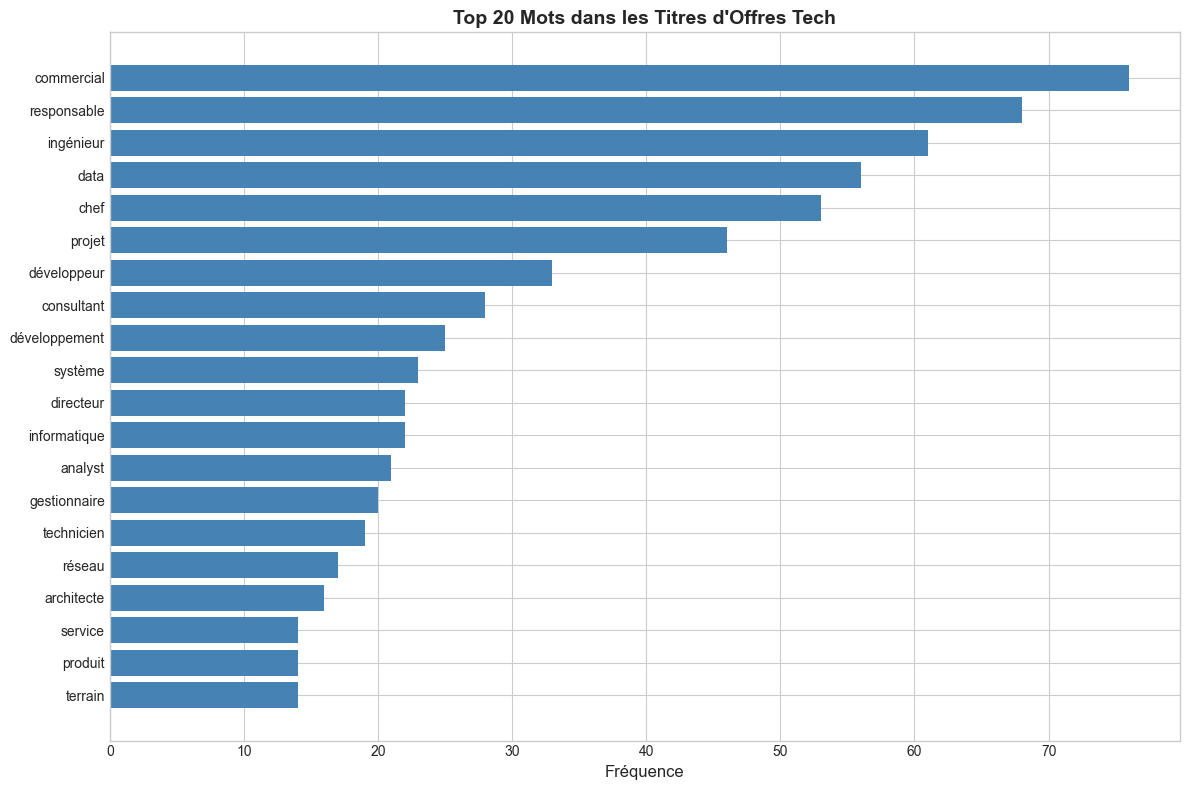

In [16]:
# Visualisation : Top 20 mots
top_20 = word_freq[:20]
words, counts = zip(*top_20)

plt.figure(figsize=(12, 8))
plt.barh(range(len(words)), counts, color='steelblue')
plt.yticks(range(len(words)), words)
plt.xlabel('Fréquence', fontsize=12)
plt.title('Top 20 Mots dans les Titres d\'Offres Tech', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 8️⃣ Vectorisation TF (Term Frequency)

In [17]:
# Préparation documents
documents = df_sample['title_lemmatized'].tolist()

print(f"📊 {len(documents)} documents prêts pour vectorisation\n")

# Paramètres
n_topics = 6  # Nombre de topics à découvrir
n_top_words = 15  # Mots par topic à afficher

# Vectorisation
vectorizer = CountVectorizer(
    max_df=0.6,       # Ignorer mots dans >60% des docs (trop communs)
    min_df=3,         # Ignorer mots dans <3 docs (trop rares)
    max_features=500, # Garder top 500 mots
    token_pattern=r'\b[a-zàâäéèêëïîôùûüÿçæœ]{3,}\b'
)

tf = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()

print(f"✅ Matrice TF créée")
print(f"   Dimensions : {tf.shape}")
print(f"   {tf.shape[0]} documents")
print(f"   {tf.shape[1]} termes uniques")

📊 500 documents prêts pour vectorisation

✅ Matrice TF créée
   Dimensions : (500, 112)
   500 documents
   112 termes uniques


## 🔄 Optimisation : Relance avec 8 Topics

D'après l'analyse de perplexité, **8 topics** offre le meilleur compromis.

In [19]:
def display_topics(model, feature_names, n_top_words):
    """Affiche les mots principaux de chaque topic"""
    topics = []
    
    for topic_idx, topic in enumerate(model.components_):
        # Indices des top mots
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append(top_words)
        
        print(f"\n📌 Topic {topic_idx + 1}")
        print(f"   Mots-clés : {', '.join(top_words[:12])}")
    
    return topics

In [20]:
# RELANCER avec 8 topics (optimal selon analyse)
print("🔄 Relance LDA avec 8 topics (nombre optimal)...\n")

n_topics = 8  # Changé de 6 à 8
n_top_words = 15

# Re-vectoriser
vectorizer = CountVectorizer(
    max_df=0.6,
    min_df=3,
    max_features=500,
    token_pattern=r'\b[a-zàâäéèêëïîôùûüÿçæœ]{3,}\b'
)

tf = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()

# Re-entraîner LDA
lda_optimal = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    max_iter=30,
    learning_method='online',
    n_jobs=-1
)

lda_optimal.fit(tf)

print("✅ LDA avec 8 topics entraîné\n")

# Afficher les nouveaux topics
print("="*80)
print("🎯 TOPICS OPTIMAUX (8 topics)")
print("="*80)

lda_topics_optimal = display_topics(lda_optimal, feature_names, n_top_words)

# Attribution
doc_topic_dist_optimal = lda_optimal.transform(tf)
df_sample['dominant_topic_8'] = doc_topic_dist_optimal.argmax(axis=1)
df_sample['topic_weight_8'] = doc_topic_dist_optimal.max(axis=1)

# Distribution
print("\n" + "="*80)
print("📊 DISTRIBUTION AVEC 8 TOPICS")
print("="*80)
print()

topic_dist_8 = df_sample['dominant_topic_8'].value_counts().sort_index()
for topic_id, count in topic_dist_8.items():
    percentage = count / len(df_sample) * 100
    print(f"   Topic {topic_id + 1} : {count:3} offres ({percentage:5.1f}%)")

🔄 Relance LDA avec 8 topics (nombre optimal)...

✅ LDA avec 8 topics entraîné

🎯 TOPICS OPTIMAUX (8 topics)

📌 Topic 1
   Mots-clés : analyste, ingénieure, ingénieur, cybersécurité, clientèle, cloud, ingenieur, partenariat, devops, informatique, industriel, linux

📌 Topic 2
   Mots-clés : consultant, manager, architecte, cloud, financier, secteur, dater, sap, groupe, maintenance, électrique, industrie

📌 Topic 3
   Mots-clés : data, analyst, digital, assistant, engineer, transformation, pari, management, transport, groupe, immobilier, support

📌 Topic 4
   Mots-clés : commercial, directeur, système, réseau, ingénieur, administrateur, marketing, terrain, gestionnaire, sénior, franchise, vente

📌 Topic 5
   Mots-clés : responsable, commercial, développement, qualité, secteur, client, gestionnaire, compte, grand, public, relation, leclerc

📌 Topic 6
   Mots-clés : chef, projet, développeur, informatique, technicien, produit, expert, gestionnaire, enquêteur, adv, gestion, terrain

📌 Topic 

## 9️⃣ Entraînement LDA (Latent Dirichlet Allocation)

In [21]:
print(f"🔄 Entraînement LDA avec {n_topics} topics...\n")

lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    max_iter=30,
    learning_method='online',
    n_jobs=-1
)

lda.fit(tf)

print("✅ LDA entraîné")

🔄 Entraînement LDA avec 8 topics...

✅ LDA entraîné


## 🔟 Affichage des Topics Découverts

In [22]:
# Afficher topics
print("\n" + "="*80)
print("🎯 TOPICS DÉCOUVERTS PAR LDA")
print("="*80)

lda_topics = display_topics(lda, feature_names, n_top_words)


🎯 TOPICS DÉCOUVERTS PAR LDA

📌 Topic 1
   Mots-clés : analyste, ingénieure, ingénieur, cybersécurité, clientèle, cloud, ingenieur, partenariat, devops, informatique, industriel, linux

📌 Topic 2
   Mots-clés : consultant, manager, architecte, cloud, financier, secteur, dater, sap, groupe, maintenance, électrique, industrie

📌 Topic 3
   Mots-clés : data, analyst, digital, assistant, engineer, transformation, pari, management, transport, groupe, immobilier, support

📌 Topic 4
   Mots-clés : commercial, directeur, système, réseau, ingénieur, administrateur, marketing, terrain, gestionnaire, sénior, franchise, vente

📌 Topic 5
   Mots-clés : responsable, commercial, développement, qualité, secteur, client, gestionnaire, compte, grand, public, relation, leclerc

📌 Topic 6
   Mots-clés : chef, projet, développeur, informatique, technicien, produit, expert, gestionnaire, enquêteur, adv, gestion, terrain

📌 Topic 7
   Mots-clés : ingénieur, développement, scientist, service, etude, devop, au

## 1️⃣1️⃣ Interprétation Manuelle des Topics

In [23]:
print("\n" + "="*80)
print("💡 INTERPRÉTATION DES TOPICS")
print("="*80)
print("""
Analysez les mots-clés ci-dessus et donnez un nom à chaque topic.

Exemples possibles :
- "Développement Backend (Java/Spring)"
- "Data Science & Machine Learning"
- "DevOps & Cloud Infrastructure"
- "Administration Systèmes & Réseaux"
- "Business Intelligence & Analytics"
- "Développement Frontend (React/Angular)"

Modifiez la liste ci-dessous selon VOS résultats :
""")

# À COMPLÉTER SELON VOS RÉSULTATS
topic_labels = [
    "Topic 1 : [À définir selon les mots-clés]",
    "Topic 2 : [À définir selon les mots-clés]",
    "Topic 3 : [À définir selon les mots-clés]",
    "Topic 4 : [À définir selon les mots-clés]",
    "Topic 5 : [À définir selon les mots-clés]",
    "Topic 6 : [À définir selon les mots-clés]",
]

print("\nLabels suggérés (à ajuster) :")
for label in topic_labels:
    print(f"   {label}")


💡 INTERPRÉTATION DES TOPICS

Analysez les mots-clés ci-dessus et donnez un nom à chaque topic.

Exemples possibles :
- "Développement Backend (Java/Spring)"
- "Data Science & Machine Learning"
- "DevOps & Cloud Infrastructure"
- "Administration Systèmes & Réseaux"
- "Business Intelligence & Analytics"
- "Développement Frontend (React/Angular)"

Modifiez la liste ci-dessous selon VOS résultats :


Labels suggérés (à ajuster) :
   Topic 1 : [À définir selon les mots-clés]
   Topic 2 : [À définir selon les mots-clés]
   Topic 3 : [À définir selon les mots-clés]
   Topic 4 : [À définir selon les mots-clés]
   Topic 5 : [À définir selon les mots-clés]
   Topic 6 : [À définir selon les mots-clés]


## 1️⃣2️⃣ Visualisation : Nuages de Mots par Topic

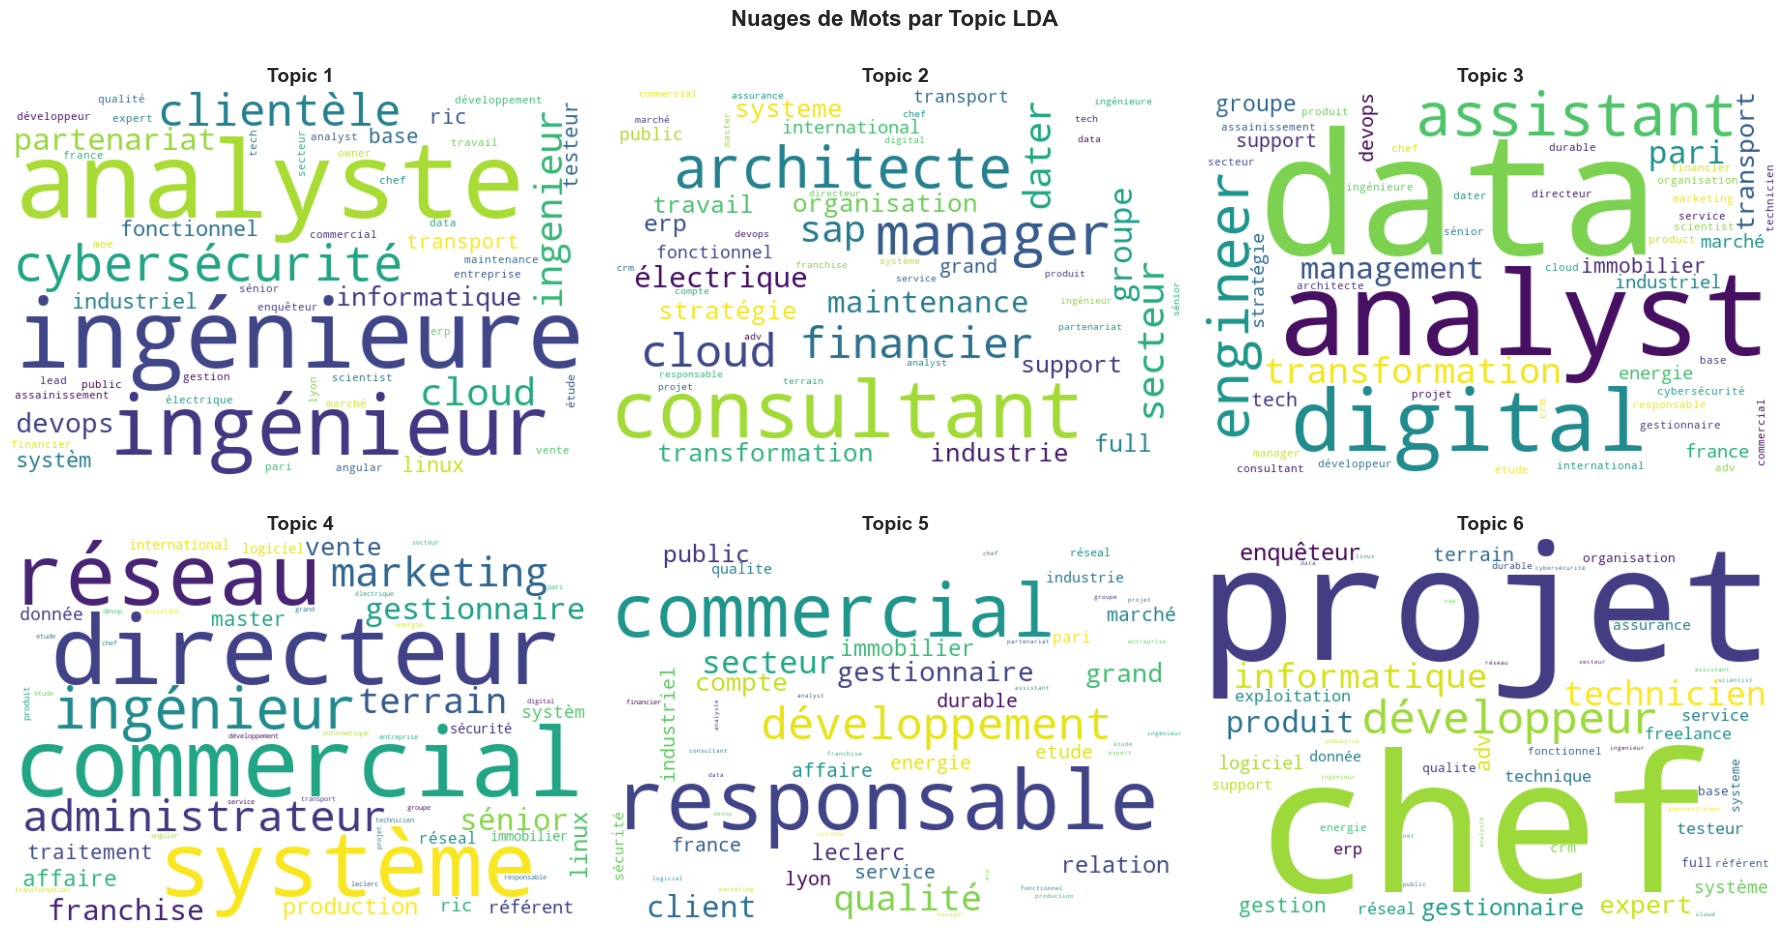

In [24]:
# Générer nuages de mots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for topic_idx, topic in enumerate(lda.components_):
    if topic_idx >= 6:
        break
    
    # Créer dictionnaire {mot: poids}
    top_words_idx = topic.argsort()[-50:][::-1]
    word_weights = {feature_names[i]: topic[i] for i in top_words_idx}
    
    # Générer nuage
    wc = WordCloud(
        width=600, 
        height=400, 
        background_color='white',
        colormap='viridis',
        relative_scaling=0.5
    ).generate_from_frequencies(word_weights)
    
    axes[topic_idx].imshow(wc, interpolation='bilinear')
    axes[topic_idx].set_title(f'Topic {topic_idx + 1}', fontsize=14, fontweight='bold')
    axes[topic_idx].axis('off')

plt.suptitle('Nuages de Mots par Topic LDA', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## 1️⃣3️⃣ Attribution Topics aux Documents

In [25]:
# Transformer documents en distribution de topics
doc_topic_dist = lda.transform(tf)

# Ajouter topic dominant à chaque offre
df_sample['dominant_topic'] = doc_topic_dist.argmax(axis=1)
df_sample['topic_weight'] = doc_topic_dist.max(axis=1)

# Statistiques
print("\n" + "="*80)
print("📊 DISTRIBUTION DES OFFRES PAR TOPIC")
print("="*80)
print()

topic_distribution = df_sample['dominant_topic'].value_counts().sort_index()

for topic_id, count in topic_distribution.items():
    percentage = count / len(df_sample) * 100
    print(f"   Topic {topic_id + 1} : {count:3} offres ({percentage:5.1f}%)")

print(f"\n   Total : {len(df_sample)} offres")


📊 DISTRIBUTION DES OFFRES PAR TOPIC

   Topic 1 :  41 offres (  8.2%)
   Topic 2 :  46 offres (  9.2%)
   Topic 3 :  47 offres (  9.4%)
   Topic 4 :  83 offres ( 16.6%)
   Topic 5 :  82 offres ( 16.4%)
   Topic 6 : 122 offres ( 24.4%)
   Topic 7 :  45 offres (  9.0%)
   Topic 8 :  34 offres (  6.8%)

   Total : 500 offres


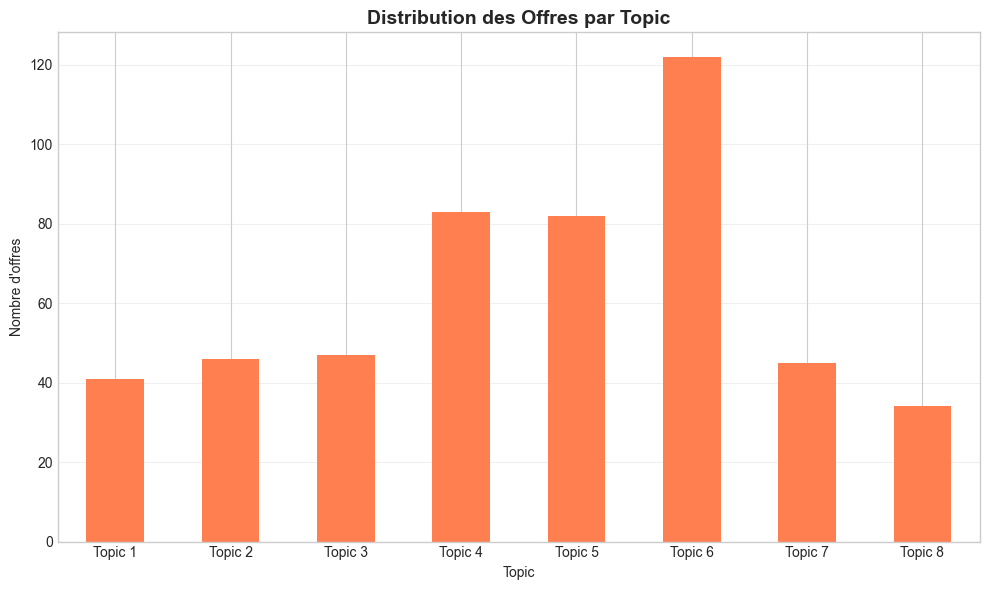

In [26]:
# Visualisation distribution
plt.figure(figsize=(10, 6))
topic_distribution.plot(kind='bar', color='coral')
plt.title('Distribution des Offres par Topic', fontsize=14, fontweight='bold')
plt.xlabel('Topic')
plt.ylabel('Nombre d\'offres')
plt.xticks([i for i in range(n_topics)], [f'Topic {i+1}' for i in range(n_topics)], rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 1️⃣4️⃣ Exemples d'Offres par Topic

In [27]:
print("\n" + "="*80)
print("📝 EXEMPLES D'OFFRES PAR TOPIC")
print("="*80)

for topic_id in range(n_topics):
    print(f"\n{'='*80}")
    print(f"🎯 Topic {topic_id + 1}")
    print(f"{'='*80}")
    
    # Mots-clés du topic
    print(f"\n   Mots-clés : {', '.join(lda_topics[topic_id][:10])}")
    
    # Prendre 3 exemples de ce topic
    examples = df_sample[
        df_sample['dominant_topic'] == topic_id
    ].nlargest(3, 'topic_weight')
    
    if len(examples) == 0:
        print("\n   Aucune offre dans ce topic")
        continue
    
    print(f"\n   Exemples d'offres :")
    for idx, row in examples.iterrows():
        print(f"\n      📌 {row['title']}")
        print(f"         Entreprise : {row['company_name']}")
        print(f"         Confiance  : {row['topic_weight']:.2%}")


📝 EXEMPLES D'OFFRES PAR TOPIC

🎯 Topic 1

   Mots-clés : analyste, ingénieure, ingénieur, cybersécurité, clientèle, cloud, ingenieur, partenariat, devops, informatique

   Exemples d'offres :

      📌 Ingénieure / Ingénieur Cloud DevOps expérimenté (H/F)
         Entreprise : Forums Talents Handicap
         Confiance  : 82.49%

      📌 Ingénieur ou Ingénieure CyberSécurité (H/F)
         Entreprise : SNCF
         Confiance  : 78.12%

      📌 COORDINATEUR·RICE EXPÉRIENCE CLIENTÈLE & ÉVÉNEMENTIEL (Saint-Leu) #TET10110 (H/F)
         Entreprise : Tetranergy Business School Réunion
         Confiance  : 70.83%

🎯 Topic 2

   Mots-clés : consultant, manager, architecte, cloud, financier, secteur, dater, sap, groupe, maintenance

   Exemples d'offres :

      📌 Consultant / Consultante en stratégie et organisation
         Entreprise : PEERS GROUP FRANCE
         Confiance  : 82.50%

      📌 Consultant Junior / Confirmé - Stratégie et Transformation - People & Organisation  - Aix-en-Prove

## 1️⃣5️⃣ Évaluation du Modèle

In [28]:
# Perplexité (plus bas = meilleur, mais attention overfitting)
perplexity = lda.perplexity(tf)

# Log-likelihood (plus haut = meilleur)
log_likelihood = lda.score(tf)

print("\n" + "="*80)
print("📈 MÉTRIQUES D'ÉVALUATION LDA")
print("="*80)
print()
print(f"   Perplexité      : {perplexity:.2f}")
print(f"   Log-likelihood  : {log_likelihood:.2f}")
print()
print("💡 Interprétation :")
print("   - Perplexité : Plus bas = meilleur ajustement")
print("   - Log-likelihood : Plus haut = meilleur modèle")
print("   - Mais la vraie qualité = interprétabilité des topics !")


📈 MÉTRIQUES D'ÉVALUATION LDA

   Perplexité      : 100.39
   Log-likelihood  : -5277.37

💡 Interprétation :
   - Perplexité : Plus bas = meilleur ajustement
   - Log-likelihood : Plus haut = meilleur modèle
   - Mais la vraie qualité = interprétabilité des topics !


## 1️⃣6️⃣ Comparaison avec NMF (Non-negative Matrix Factorization)

In [29]:
print("🔄 Entraînement NMF pour comparaison...\n")

# Vectorisation TF-IDF pour NMF
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.6,
    min_df=3,
    max_features=500,
    token_pattern=r'\b[a-zàâäéèêëïîôùûüÿçæœ]{3,}\b'
)

tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Entraîner NMF
nmf = NMF(
    n_components=n_topics,
    random_state=42,
    max_iter=200
)

nmf.fit(tfidf)

print("✅ NMF entraîné\n")

# Afficher topics NMF
print("="*80)
print("🎯 TOPICS DÉCOUVERTS PAR NMF")
print("="*80)

nmf_topics = display_topics(nmf, tfidf_feature_names, n_top_words)

🔄 Entraînement NMF pour comparaison...

✅ NMF entraîné

🎯 TOPICS DÉCOUVERTS PAR NMF

📌 Topic 1
   Mots-clés : responsable, commercial, développement, franchise, qualité, affaire, digital, compte, secteur, grand, france, leclerc

📌 Topic 2
   Mots-clés : chef, projet, produit, technique, logiciel, crm, erp, informatique, réseal, référent, assistant, assurance

📌 Topic 3
   Mots-clés : ingénieur, développement, ingénieure, étude, système, etude, linux, production, réseau, devop, logiciel, net

📌 Topic 4
   Mots-clés : développeur, java, analyste, full, linux, erp, administrateur, sénior, net, angular, lyon, service

📌 Topic 5
   Mots-clés : data, analyst, scientist, engineer, assistant, architecte, manager, analyste, immobilier, international, groupe, cloud

📌 Topic 6
   Mots-clés : directeur, commercial, terrain, marketing, transformation, vente, système, architecte, sénior, franchise, groupe, transport

📌 Topic 7
   Mots-clés : consultant, manager, financier, sap, secteur, support, tra

## 1️⃣7️⃣ Comparaison LDA vs NMF

In [30]:
print("\n" + "="*80)
print("⚖️  COMPARAISON LDA vs NMF")
print("="*80)

for i in range(n_topics):
    print(f"\n📊 Topic {i+1}")
    print(f"   LDA : {', '.join(lda_topics[i][:8])}")
    print(f"   NMF : {', '.join(nmf_topics[i][:8])}")

print("\n" + "="*80)
print("💡 OBSERVATIONS")
print("="*80)
print("""
LDA (Latent Dirichlet Allocation) :
   ✓ Modèle probabiliste génératif
   ✓ Topics plus "mélangés" (chaque doc = mix de topics)
   ✓ Meilleur pour découvrir thèmes sous-jacents

NMF (Non-negative Matrix Factorization) :
   ✓ Factorisation matricielle
   ✓ Topics plus "nets" et séparés
   ✓ Meilleur pour catégorisation stricte

Choisir selon : Cohérence et interprétabilité des topics pour votre projet.
""")


⚖️  COMPARAISON LDA vs NMF

📊 Topic 1
   LDA : analyste, ingénieure, ingénieur, cybersécurité, clientèle, cloud, ingenieur, partenariat
   NMF : responsable, commercial, développement, franchise, qualité, affaire, digital, compte

📊 Topic 2
   LDA : consultant, manager, architecte, cloud, financier, secteur, dater, sap
   NMF : chef, projet, produit, technique, logiciel, crm, erp, informatique

📊 Topic 3
   LDA : data, analyst, digital, assistant, engineer, transformation, pari, management
   NMF : ingénieur, développement, ingénieure, étude, système, etude, linux, production

📊 Topic 4
   LDA : commercial, directeur, système, réseau, ingénieur, administrateur, marketing, terrain
   NMF : développeur, java, analyste, full, linux, erp, administrateur, sénior

📊 Topic 5
   LDA : responsable, commercial, développement, qualité, secteur, client, gestionnaire, compte
   NMF : data, analyst, scientist, engineer, assistant, architecte, manager, analyste

📊 Topic 6
   LDA : chef, projet, déve

## 1️⃣8️⃣ Trouver le Nombre Optimal de Topics

In [31]:
print("🔄 Test de différents nombres de topics (3 à 10)...\n")

n_topics_range = range(3, 11)
perplexities = []
log_likelihoods = []

for n in n_topics_range:
    lda_temp = LatentDirichletAllocation(
        n_components=n,
        random_state=42,
        max_iter=20
    )
    lda_temp.fit(tf)
    
    perp = lda_temp.perplexity(tf)
    ll = lda_temp.score(tf)
    
    perplexities.append(perp)
    log_likelihoods.append(ll)
    
    print(f"   {n} topics : perplexité = {perp:.2f}, log-likelihood = {ll:.2f}")

print("\n✅ Tests terminés")

🔄 Test de différents nombres de topics (3 à 10)...

   3 topics : perplexité = 83.87, log-likelihood = -5071.47
   4 topics : perplexité = 92.55, log-likelihood = -5184.23
   5 topics : perplexité = 100.48, log-likelihood = -5278.45
   6 topics : perplexité = 94.76, log-likelihood = -5211.24
   7 topics : perplexité = 94.99, log-likelihood = -5214.04
   8 topics : perplexité = 100.73, log-likelihood = -5281.24
   9 topics : perplexité = 100.76, log-likelihood = -5281.57
   10 topics : perplexité = 97.56, log-likelihood = -5244.60

✅ Tests terminés


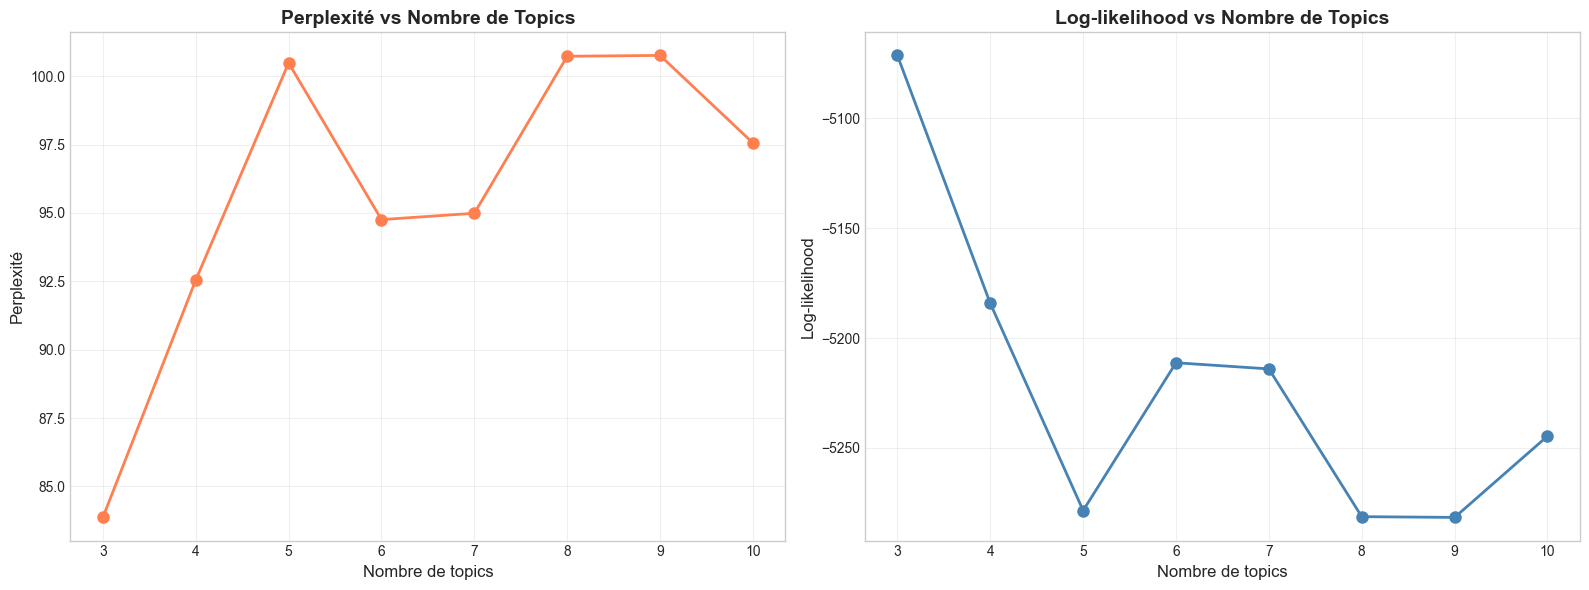


💡 Chercher le 'coude' où les courbes se stabilisent.
   C'est souvent le nombre optimal de topics.


In [32]:
# Visualisation courbes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Perplexité
ax1.plot(n_topics_range, perplexities, marker='o', linewidth=2, markersize=8, color='coral')
ax1.set_xlabel('Nombre de topics', fontsize=12)
ax1.set_ylabel('Perplexité', fontsize=12)
ax1.set_title('Perplexité vs Nombre de Topics', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(n_topics_range)

# Log-likelihood
ax2.plot(n_topics_range, log_likelihoods, marker='o', linewidth=2, markersize=8, color='steelblue')
ax2.set_xlabel('Nombre de topics', fontsize=12)
ax2.set_ylabel('Log-likelihood', fontsize=12)
ax2.set_title('Log-likelihood vs Nombre de Topics', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(n_topics_range)

plt.tight_layout()
plt.show()

print("\n💡 Chercher le 'coude' où les courbes se stabilisent.")
print("   C'est souvent le nombre optimal de topics.")